In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.linear_model import LinearRegression

## data

### load data

In [43]:
# folder that has the data
folder = r'C:\Users\weaveae\OneDrive - University of Cincinnati\Classes\S02 Physics 2\Lab'

# build a dictionary of dataframes from the different runs, and add a column for the run number
rawdat = {"dat_{}".format(i): pd.read_csv("{}\\harmonic osc data\\Run {} sg.csv".format(folder, i)).assign(run=i) for i in range(1, 6)}

# rename the columns in each df to be time, position, velocity, and run number, and then reorganize the columns so run is first
for i in range(1, 6):
    rawdat['dat_{}'.format(i)].columns = ['time', 'position', 'velocity', 'run']
    rawdat['dat_{}'.format(i)] = rawdat['dat_{}'.format(i)][['run', 'time', 'position', 'velocity']]

# combine the dataframes into one and reset the index
df = pd.concat([rawdat['dat_{}'.format(i)] for i in range(1, 5)]).reset_index(drop=True)

# map the mass to the run number
mass_map = {"{}".format(i+1):[0.02,0.07,0.17,0.22,0.24][i] for i in range(5)}
df['mass'] = df['run'].astype(str).map(mass_map)

df.head()

,run,time,position,velocity,mass
0,1,0.00,0.33,NaN,0.02
1,1,0.05,0.32,-0.26,0.02
2,1,0.10,0.30,-0.43,0.02
3,1,0.15,0.27,-0.51,0.02
4,1,0.20,0.25,-0.49,0.02


### plot data to check

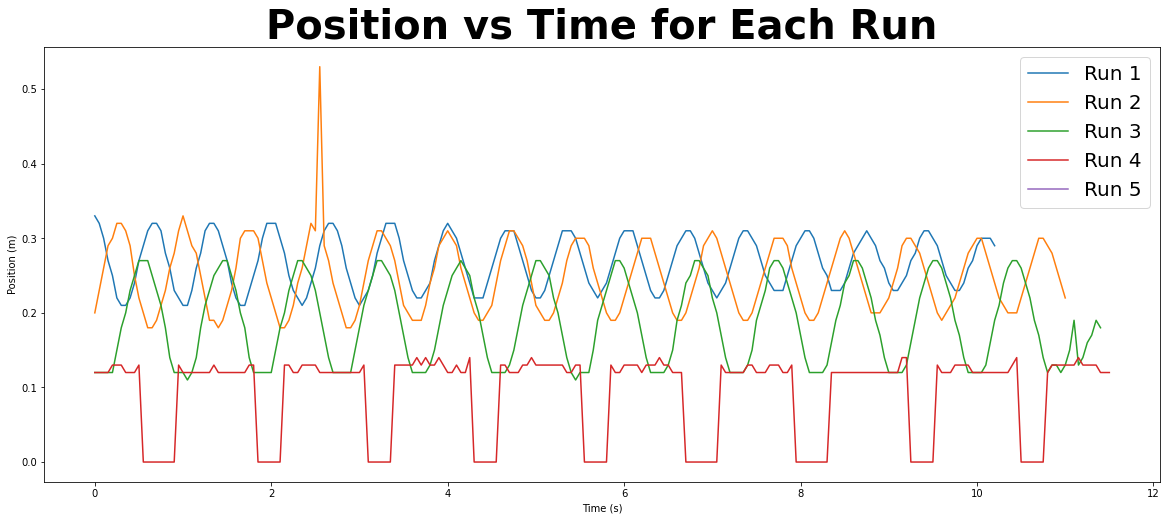

In [44]:
# plot the data (position vs time) for each run
for i in range(1, 6):
    plt.plot(df[df['run']==i]['time'], df[df['run']==i]['position'], label='Run {}'.format(i))

# add labels and a legend
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()

# make the plot larger
plt.rcParams['figure.figsize'] = [20, 8]

# add a title to the plot
plt.title('Position vs Time for Each Run')

# plot the data (position vs time) for each run
plt.show()


### remove data errors

Because run #4 looks like an equipment malfunction and run #5 is missing entirely, they will be removed from further consideration:

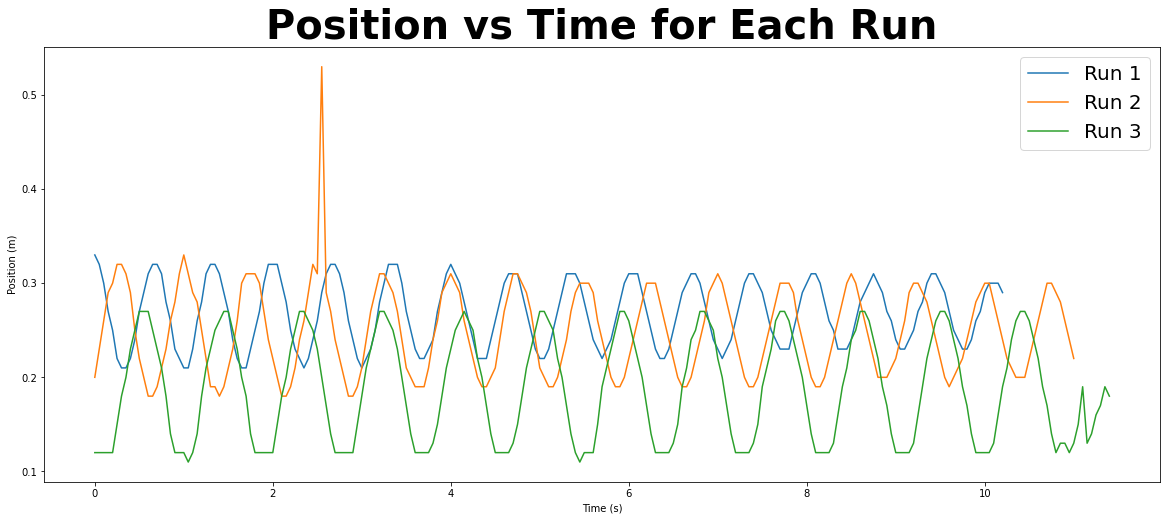

In [45]:
# drop runs 4 and 5
df = df.loc[np.logical_and(df['run'] != 5, df['run'] != 4), :]

# remake the same plot as above
for i in range(1, 4):
    plt.plot(df[df['run']==i]['time'], df[df['run']==i]['position'], label='Run {}'.format(i))
    
plt.xlabel('Time (s)')
plt.ylabel('Position (m)')
plt.legend()
plt.rcParams['figure.figsize'] = [20, 10]
plt.title('Position vs Time for Each Run')
plt.show()

## $T^2$ vs $M$
$$ T^2 = \left( \frac{4\pi^2}{k} \right) M + \left[ 4 \pi^2 \left( \frac{cm_{spring}}{k} \right)  \right]$$  

Eg this means that $T^2$ is linear in $M$ with slope $\left( \frac{4\pi^2}{k} \right)$ and intercept $\left[ 4 \pi^2 \left( \frac{cm_{spring}}{k} \right)  \right]$


### check idea by plotting velocity vs time to test feasibility of obtaining peaks this way

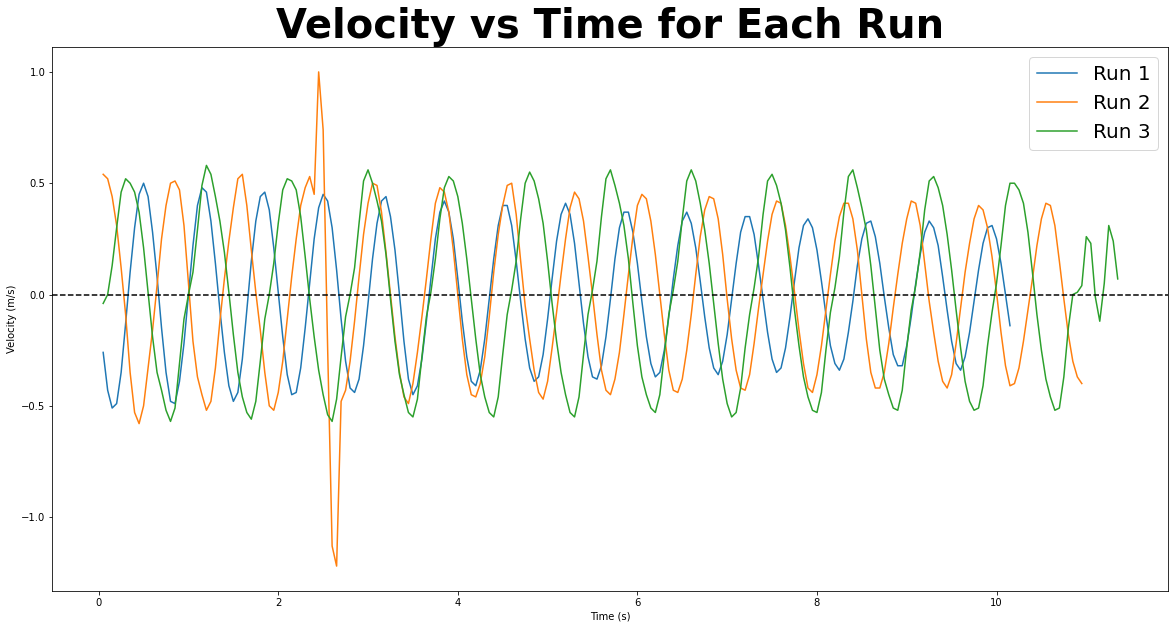

In [46]:
# plot velocity vs time for each run
for i in range(1, 4):
    plt.plot(df[df['run']==i]['time'], df[df['run']==i]['velocity'], label='Run {}'.format(i))

# also add a horizontal black dotted line at y=0
plt.axhline(y=0, color='k', linestyle='--')


plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()

plt.rcParams['figure.figsize'] = [20, 8]
plt.title('Velocity vs Time for Each Run')
plt.show()


### find places where velocity changes from positive to negative
then interpolate to estimate where the velocity is 0 (indicating a peak)

In [71]:
# determine the period of each run
# the period is the average time between peaks
# the peaks are the LOCAL maxima of the position vs time plot
# the peaks are the points where the velocity is 0

# locate the points where the velocity is changes sign
# the points where the velocity is 0 will be between these points

# make a new column that is the sign of the velocity
df['sign'] = np.sign(df['velocity'])

# make a new column that is the difference between the sign of the velocity and the sign of the velocity shifted by 1
df['diff'] = df['sign'] - df['sign'].shift(1)

# make a new table that only has the rows where diff is 2 
# taking only the posittive sign change, and not the negative sign change,
# will ensure that the points are only the peaks and not the troughs

# make a new column that is the time shifted by 1 (this will be used to calculate the period)
df['prior_time'] = df['time'].shift(1)

period_df = df[df['diff'] == 2]

period_df.head()

,run,time,position,velocity,mass,sign,diff,prior_time
7,1,0.35,0.21,0.10,0.02,1.0,2.0,0.30
21,1,1.05,0.21,0.22,0.02,1.0,2.0,1.00
34,1,1.70,0.21,0.15,0.02,1.0,2.0,1.65
47,1,2.35,0.21,0.05,0.02,1.0,2.0,2.30
61,1,3.05,0.22,0.16,0.02,1.0,2.0,3.00


In [63]:
# get the indices of the rows in period_df
# these will be used to get the time values from the original df
final_time = period_df.index.tolist()

# now get the initial time indices, which are the final time indices minus 1
initial_time = [i-1 for i in final_time]

# filter the original df to only include the rows with the initial and final time indices
# and then sort the rows by the index
time_change_df = df.loc[initial_time + final_time, :].sort_index()

# add a column for `time` - `prior_time`
time_change_df['time_diff'] = time_change_df['time'] - time_change_df['prior_time']

# create a new column that is the prior_velocity (velocity shifted by 1)
time_change_df['prior_velocity'] = time_change_df['velocity'].shift(1)

# filter out columns whose (run, prior_time) tuple is not in the (run, time) tuple
# this will ensure that the initial and final time values are from the same run
time_change_df = (
  time_change_df
  .merge(df[['run', 'time', 'velocity']].assign(v2=df.velocity.shift(1)), on=['run', 'time'], how='left')
  .drop(columns="velocity_y sign diff".split())
  .rename(columns={"velocity_x": "velocity"})
)

time_change_df = time_change_df[time_change_df['prior_velocity'] == time_change_df['v2']].drop(columns='v2')

# now assume the velocity is changing linearly between the prior_time and time columns
# and interpolate the time at the peak (where velocity is 0)
# this will give the time at the peak
time_change_df['time_at_peak'] = time_change_df['time'] - time_change_df['velocity'] * time_change_df['time_diff'] / (time_change_df['velocity'] - time_change_df['prior_velocity'])

# now that we have the time at the peak, we can calculate the period
time_change_df['period'] = time_change_df['time_at_peak'] - time_change_df['time_at_peak'].shift(1)

time_change_df.head()

,run,time,position,velocity,mass,prior_time,time_diff,prior_velocity,time_at_peak,period
1,1,0.35,0.21,0.10,0.02,0.30,0.05,-0.130000,0.328261,NaN
3,1,1.05,0.21,0.22,0.02,1.00,0.05,-0.000586,1.000133,0.671872
5,1,1.70,0.21,0.15,0.02,1.65,0.05,-0.070000,1.665909,0.665776
7,1,2.35,0.21,0.05,0.02,2.30,0.05,-0.150000,2.337500,0.671591
9,1,3.05,0.22,0.16,0.02,3.00,0.05,-0.040000,3.010000,0.672500


In [78]:
# make a dataset to use for plotting and the regression model
model_dat = time_change_df.copy().dropna()

# rename some columns/make copies of some columns
model_dat['t2'] = model_dat['period']**2
model_dat['m'] = model_dat['mass']
model_dat.head()

,run,time,position,velocity,mass,prior_time,time_diff,prior_velocity,time_at_peak,period,t2,m
3,1,1.05,0.21,0.22,0.02,1.00,0.05,-0.000586,1.000133,0.671872,0.451412,0.02
5,1,1.70,0.21,0.15,0.02,1.65,0.05,-0.070000,1.665909,0.665776,0.443258,0.02
7,1,2.35,0.21,0.05,0.02,2.30,0.05,-0.150000,2.337500,0.671591,0.451034,0.02
9,1,3.05,0.22,0.16,0.02,3.00,0.05,-0.040000,3.010000,0.672500,0.452256,0.02
11,1,3.70,0.22,0.07,0.02,3.65,0.05,-0.120000,3.681579,0.671579,0.451018,0.02


<AxesSubplot:title={'center':'period'}, xlabel='run'>

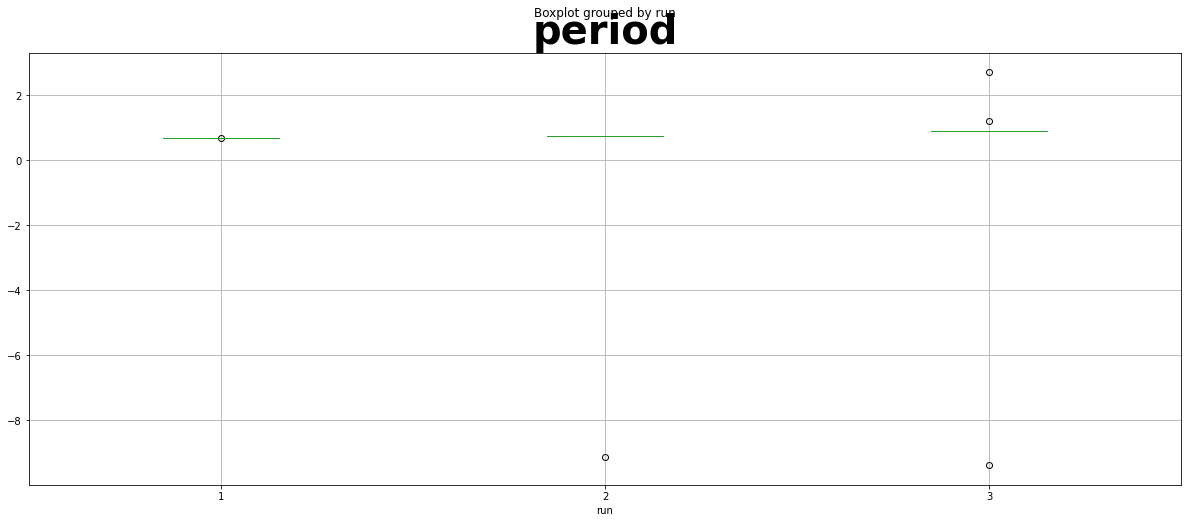

In [82]:
# again check the data
# look at boxplots of the period for each run
model_dat.boxplot(column='period', by='run')

In [83]:
# significant outliers in run 2 and 3
# view the outliers in run 2:
model_dat[model_dat['run'] == 2]['period']

31   -9.120714
33    0.741579
35    0.747368
37    0.751053
39    0.749412
41    0.745588
43    0.748529
45    0.751471
47    0.750000
49    0.745000
51    0.751875
53    0.748125
55    0.748750
57    0.756250
Name: period, dtype: float64

In [84]:
# need to drop index 31, because a negative period is not possible
# first want to check run 3 to see if there are any other outliers
model_dat[model_dat['run'] == 3]['period']

59   -9.374657
61    2.695112
63    0.895455
65    0.900000
67    0.900000
69    0.896591
71    0.898864
73    0.895455
75    0.898951
77    1.204525
Name: period, dtype: float64

<AxesSubplot:title={'center':'period'}, xlabel='run'>

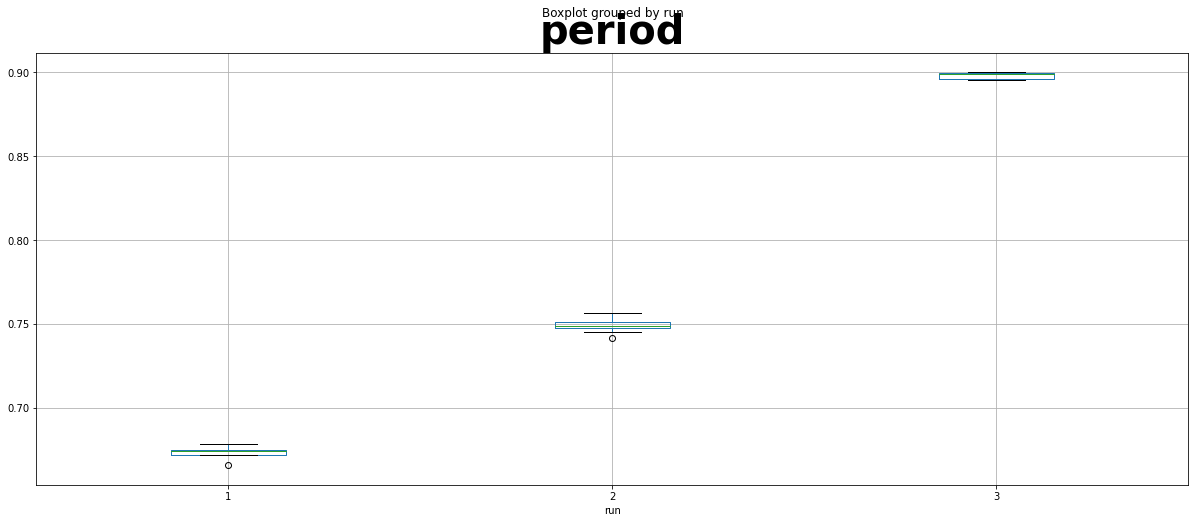

In [85]:
# three of theses values are outliers: index 59, 61, and 77

# now drop all four outliers:
model_dat = model_dat.drop([31, 59, 61, 77])

# now check the boxplots again
model_dat.boxplot(column='period', by='run')

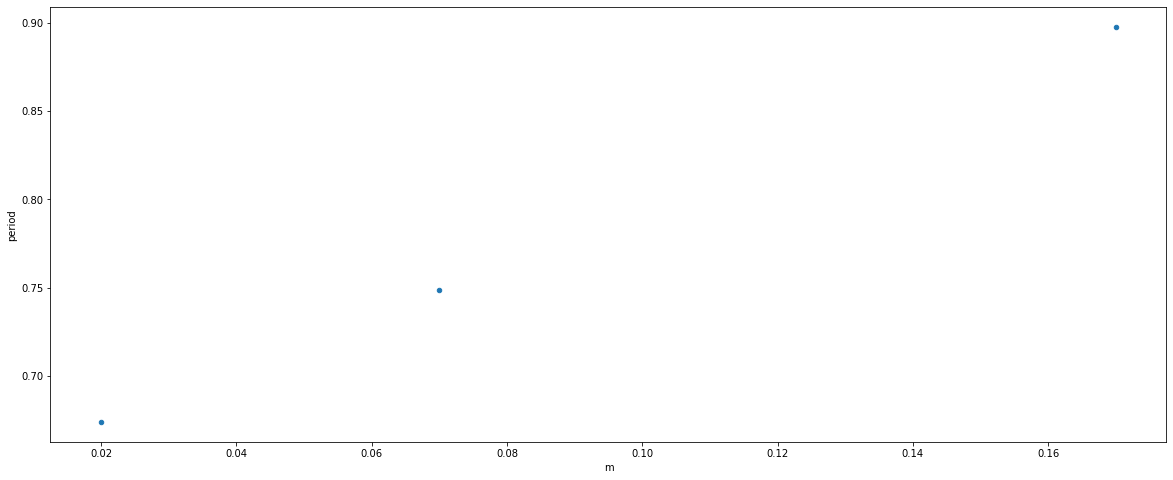

In [90]:
# this looks much better, and it looks like the period increases with mass
# now look at the actual relationship between average period and mass:

# plot the average period vs mass
model_dat[['period', 'm']].groupby('m').mean().reset_index().plot(kind='scatter', x='m', y='period');

besides a handful of data errors that were apparent looking at the plots above, this seems to be sucessful

## fit linear model to these data

In [93]:
lm = LinearRegression().fit(model_dat[['m']], model_dat['period']**2)
print('slope:', lm.coef_[0].round(3))
print('intercept:', lm.intercept_.round(3))
print('R^2:', lm.score(model_dat[['m']], model_dat['period']**2).round(3))

slope: 2.349
intercept: 0.403
R^2: 0.997


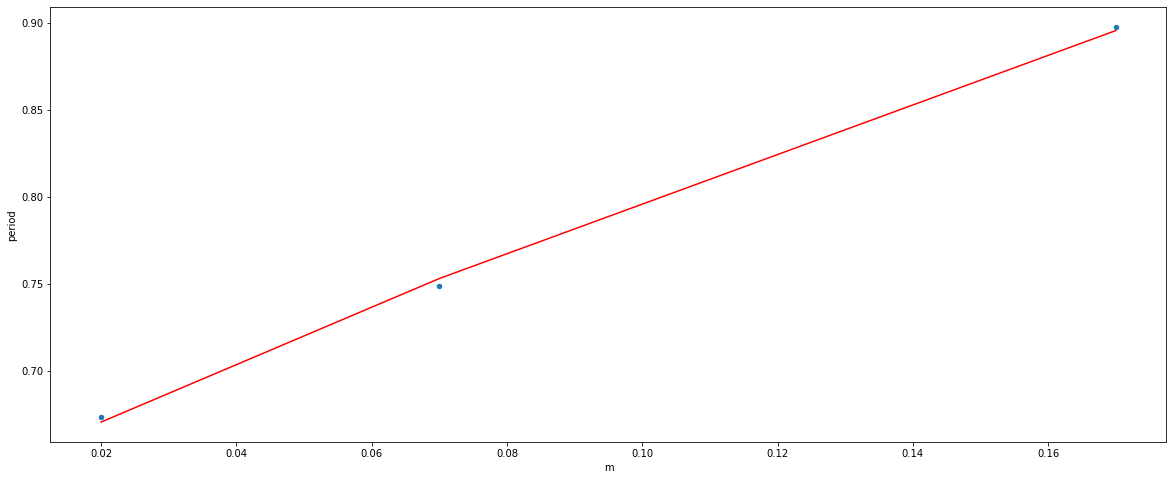

In [95]:
# plot the data and the regression line
model_dat[['period', 'm']].groupby('m').mean().reset_index().plot(kind='scatter', x='m', y='period')
plt.plot(model_dat['m'], np.sqrt(lm.predict(model_dat[['m']])), color='red')
plt.show()

### finding $c$ and $k$

Recall from above that

$$ T^2 = \left( \frac{4\pi^2}{k} \right) M + \left[ 4 \pi^2 \left( \frac{cm_{spring}}{k} \right)  \right]$$

This means that we can consider the slope equal to $\left( \frac{4\pi^2}{k} \right)$ and the intercept equal to $\left[ 4 \pi^2 \left( \frac{cm_{spring}}{k} \right)  \right]$.

Given the regression coefficients above, can solve for $c$ and $k$. 



In [96]:
# find $k$, which is 4pi^2 / slope (based on the equation for the period above)
k = 4 * np.pi**2 / lm.coef_[0]

# given that the mass of the spring is 0.159 kg, find $c$ using the k just calculated, 
# and the intercept of the regression line
c = ((lm.intercept_ / (4*np.pi**2)) * k) / 0.159

# print the values of k and c
print('k:', k.round(3))
print('c:', c.round(3))

k: 16.809
c: 1.079
